In [1]:
# Cell 2: Imports & basic setup

import random
from collections import deque

import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# Cell 3: Replay buffer and Q-network definition

class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states      = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        actions     = np.array(actions, dtype=np.int64)
        rewards     = np.array(rewards, dtype=np.float32)
        dones       = np.array(dones, dtype=np.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
        )

    def forward(self, x):
        return self.net(x)


In [3]:
# Cell 4: DDQN agent (online network selects action, target network evaluates)

class DDQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        gamma=0.99,
        lr=5e-4,
        batch_size=64,
        buffer_capacity=100_000,
        epsilon_start=1.0,
        epsilon_end=0.05,
        epsilon_decay=0.997,
        target_update_every=10,
        device=None,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.target_update_every = target_update_every

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Online and target networks
        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)

        self.replay_buffer = ReplayBuffer(buffer_capacity)
        self.train_steps = 0

    def select_action(self, state, explore=True):
        # epsilon-greedy
        if explore and random.random() < self.epsilon:
            return random.randrange(self.action_dim)

        state_t = torch.as_tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_net(state_t)
            action = int(torch.argmax(q_values, dim=1).item())
        return action

    def update(self):
        # replay warmup: wait until buffer has enough transitions
        if len(self.replay_buffer) < max(self.batch_size, 1000):
            return None

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        states_t      = torch.as_tensor(states, dtype=torch.float32, device=self.device)
        next_states_t = torch.as_tensor(next_states, dtype=torch.float32, device=self.device)
        actions_t     = torch.as_tensor(actions, dtype=torch.int64, device=self.device).unsqueeze(1)
        rewards_t     = torch.as_tensor(rewards, dtype=torch.float32, device=self.device)
        dones_t       = torch.as_tensor(dones, dtype=torch.float32, device=self.device)

        # Q(s,a) for taken actions (online network)
        q_values = self.q_net(states_t).gather(1, actions_t).squeeze(1)

        # --- Double DQN target ---
        # 1) Use online net to choose best action at next state
        with torch.no_grad():
            next_q_online = self.q_net(next_states_t)  # Q_theta(s', a)
            next_actions  = torch.argmax(next_q_online, dim=1, keepdim=True)  # a* = argmax_a Q_theta(s',a)

            # 2) Use target net to evaluate that action
            next_q_target = self.target_net(next_states_t).gather(1, next_actions).squeeze(1)

            target_q = rewards_t + self.gamma * next_q_target * (1.0 - dones_t)

        # MSE loss
        loss = nn.MSELoss()(q_values, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1.0)
        self.optimizer.step()

        self.train_steps += 1
        if self.train_steps % self.target_update_every == 0:
            self.update_target_net()

        return float(loss.item())

    def update_target_net(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)


In [ ]:
# Cell 5: Training loop for DDQN on LunarLander

def train_ddqn(
    num_episodes=1000,
    max_steps_per_episode=1000,
    env_name="LunarLander-v3",
    solved_score=200.0,
    print_every=10,
):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DDQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        gamma=0.99,
        lr=5e-4,
        batch_size=64,
        buffer_capacity=100_000,
        epsilon_start=1.0,
        epsilon_end=0.01,
        epsilon_decay=0.990,
        target_update_every=10,
        device=device,
    )

    scores = []
    moving_avgs = []
    eps_history = []

    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        total_reward = 0.0

        for t in range(max_steps_per_episode):
            action = agent.select_action(state, explore=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.replay_buffer.push(state, action, reward, next_state, done)
            loss = agent.update()

            state = next_state
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        moving_avg = np.mean(scores[-10:])
        moving_avgs.append(moving_avg)

        agent.decay_epsilon()
        eps_history.append(agent.epsilon)

        if episode % print_every == 0:
            print(
                f"Episode {episode:4d} | "
                f"Score: {total_reward:8.2f} | "
                f"Avg(10): {moving_avg:8.2f} | "
                f"Epsilon: {agent.epsilon:.3f}"
            )

        # Zaustavitveni pogoj: povprečje zadnjih 10 epizod >= 200
        if moving_avg >= solved_score and episode >= 10:
            print(f"Solved environment in {episode} episodes! Moving average score = {moving_avg:.2f}")
            break

    env.close()

    # Plot: episode returns + moving average
    plt.figure()
    plt.plot(scores, label="Score per episode")
    plt.plot(moving_avgs, label="Moving average (last 10)")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("DDQN on LunarLander-v3")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ddqn_lunarlander_scores.png", dpi=150)
    plt.show()

    # Plot: epsilon decay
    plt.figure()
    plt.plot(eps_history)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon decay (DDQN)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ddqn_lunarlander_epsilon.png", dpi=150)
    plt.show()

    return agent, scores, moving_avgs


In [5]:
# Cell 6: Create GIF of trained DDQN agent

def make_gif(
    agent: DDQNAgent,
    filename="ddqn_lunarlander.gif",
    env_name="LunarLander-v3",
    episodes=1,
    max_steps_per_episode=1000,
    fps=30,
):
    env = gym.make(env_name, render_mode="rgb_array")
    frames = []

    for ep in range(episodes):
        state, _ = env.reset()
        for t in range(max_steps_per_episode):
            # Greedy policy (brez raziskovanja)
            action = agent.select_action(state, explore=False)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            frame = env.render()
            frames.append(frame)

            state = next_state
            if done:
                break

    env.close()

    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved GIF to {filename}")


/Users/viktorrackov/Desktop/Feri/3.semestar/Globoke/.venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


Episode   10 | Score:  -143.83 | Avg(10):  -204.02 | Epsilon: 0.970
Episode   20 | Score:  -145.66 | Avg(10):  -190.62 | Epsilon: 0.942
Episode   30 | Score:  -227.45 | Avg(10):   -95.77 | Epsilon: 0.914
Episode   40 | Score:  -163.21 | Avg(10):  -187.32 | Epsilon: 0.887
Episode   50 | Score:   -65.96 | Avg(10):  -123.51 | Epsilon: 0.861
Episode   60 | Score:  -143.94 | Avg(10):  -123.50 | Epsilon: 0.835
Episode   70 | Score:   -37.48 | Avg(10):  -103.64 | Epsilon: 0.810
Episode   80 | Score:  -127.48 | Avg(10):  -140.74 | Epsilon: 0.786
Episode   90 | Score:   -52.05 | Avg(10):  -143.19 | Epsilon: 0.763
Episode  100 | Score:   -85.14 | Avg(10):  -100.51 | Epsilon: 0.740
Episode  110 | Score:   -85.75 | Avg(10):  -110.63 | Epsilon: 0.719
Episode  120 | Score:   -80.32 | Avg(10):   -94.72 | Epsilon: 0.697
Episode  130 | Score:   -62.72 | Avg(10):   -64.86 | Epsilon: 0.677
Episode  140 | Score:   -48.44 | Avg(10):   -94.24 | Epsilon: 0.657
Episode  150 | Score:   -52.74 | Avg(10):   -88.

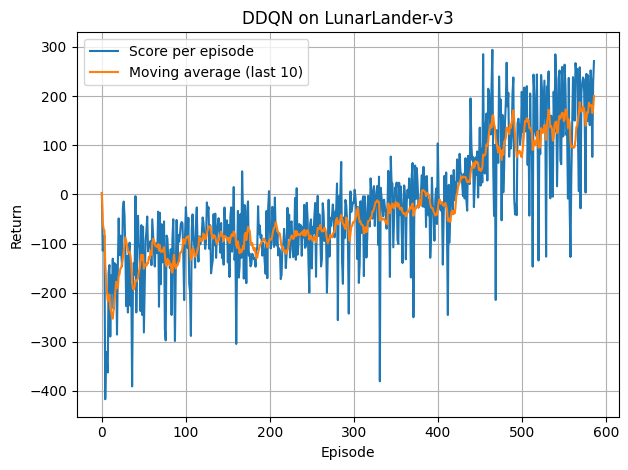

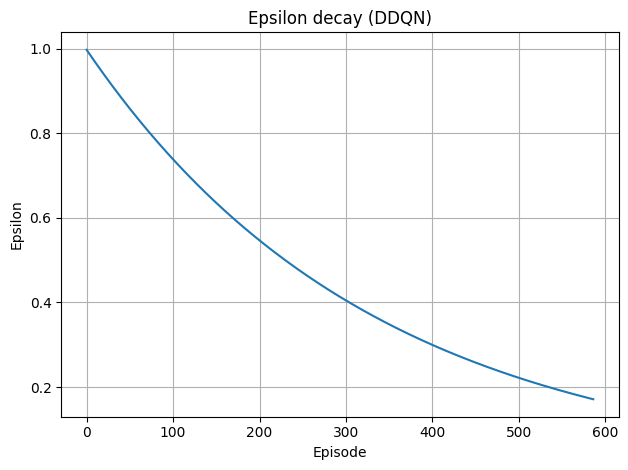

Saved GIF to V4.2-Viktor-Rackov-lunarlander-DDQN.gif


In [6]:
# Cell 7: Train DDQN agent and generate GIF

agent, scores, moving_avgs = train_ddqn(
    num_episodes=1000,
    max_steps_per_episode=1000,
    env_name="LunarLander-v3",
    solved_score=200.0,   # pogoj: povprečje zadnjih 10 epizod >= 200
    print_every=10,
)

make_gif(
    agent,
    filename="V4.2-Viktor-Rackov-lunarlander-DDQN.gif",
    env_name="LunarLander-v3",
    episodes=1,
    max_steps_per_episode=1000,
    fps=30,
)
